# Pixel centroid changes and mnemonics | PID 2079 Example

For this example, we will use the JWST engineering telemetry database to overplot mnemonmics and events over our timeseries. Mnemonics are useful in detecting anomalies in guidestar data and differentiating technical events on the JWST from the guidestar flux. We will use PID 2079, observation number 4, and visit number 1 and find out if there are any technical anomalies in our data using Spelunker.

First, load the program ID.

In [1]:
cd /Users/galagabits/Developer/FGS-Spelunker/

/Users/galagabits/Developer/FGS-Spelunker


In [3]:
import spelunker

spk = spelunker.load()
spk.readfile(pid=2079, obs_num=4, visit=1)

Current working directory for spelunker: /Users/galagabits/Developer/FGS-Spelunker/spelunker_outputs

['/Users/galagabits/Developer/FGS-Spelunker/spelunker_outputs/mastDownload/JWST/jw02079004001_10101_00004_nis/jw02079004001_gs-fg_2023031214828-seg001_cal.fits', '/Users/galagabits/Developer/FGS-Spelunker/spelunker_outputs/mastDownload/JWST/jw02079004001_10101_00004_nis/jw02079004001_gs-fg_2023031214828-seg002_cal.fits', '/Users/galagabits/Developer/FGS-Spelunker/spelunker_outputs/mastDownload/JWST/jw02079004001_10101_00004_nis/jw02079004001_gs-fg_2023031214829-seg001_cal.fits', '/Users/galagabits/Developer/FGS-Spelunker/spelunker_outputs/mastDownload/JWST/jw02079004001_10101_00004_nis/jw02079004001_gs-fg_2023031214829-seg002_cal.fits', '/Users/galagabits/Developer/FGS-Spelunker/spelunker_outputs/mastDownload/JWST/jw02079004001_10101_00004_nis/jw02079004001_gs-fg_2023031231651-seg003_cal.fits', '/Users/galagabits/Developer/FGS-Spelunker/spelunker_outputs/mastDownload/JWST/jw02079004001

You will need to input your MAST API Token to access JWST Engineering Telemetry and mnemonics.

In [14]:
import os

spk.mast_api_token = os.environ.get('MAST_API_TOKEN')

Lets look at how many guidestars this program uses.

In [10]:
spk.object_properties

,guidestar_catalog_id,GAIAdr3sourceID,int_start,int_stop,ra,dec,Jmag,Hmag
0,S33T007497,5057488505467609856,59975.839346,59975.877272,53.227852,-27.900351,13.7611,13.2482


There is only one guidestar used within this program. Lets look at the flux timeseries for the guidestar in the program.

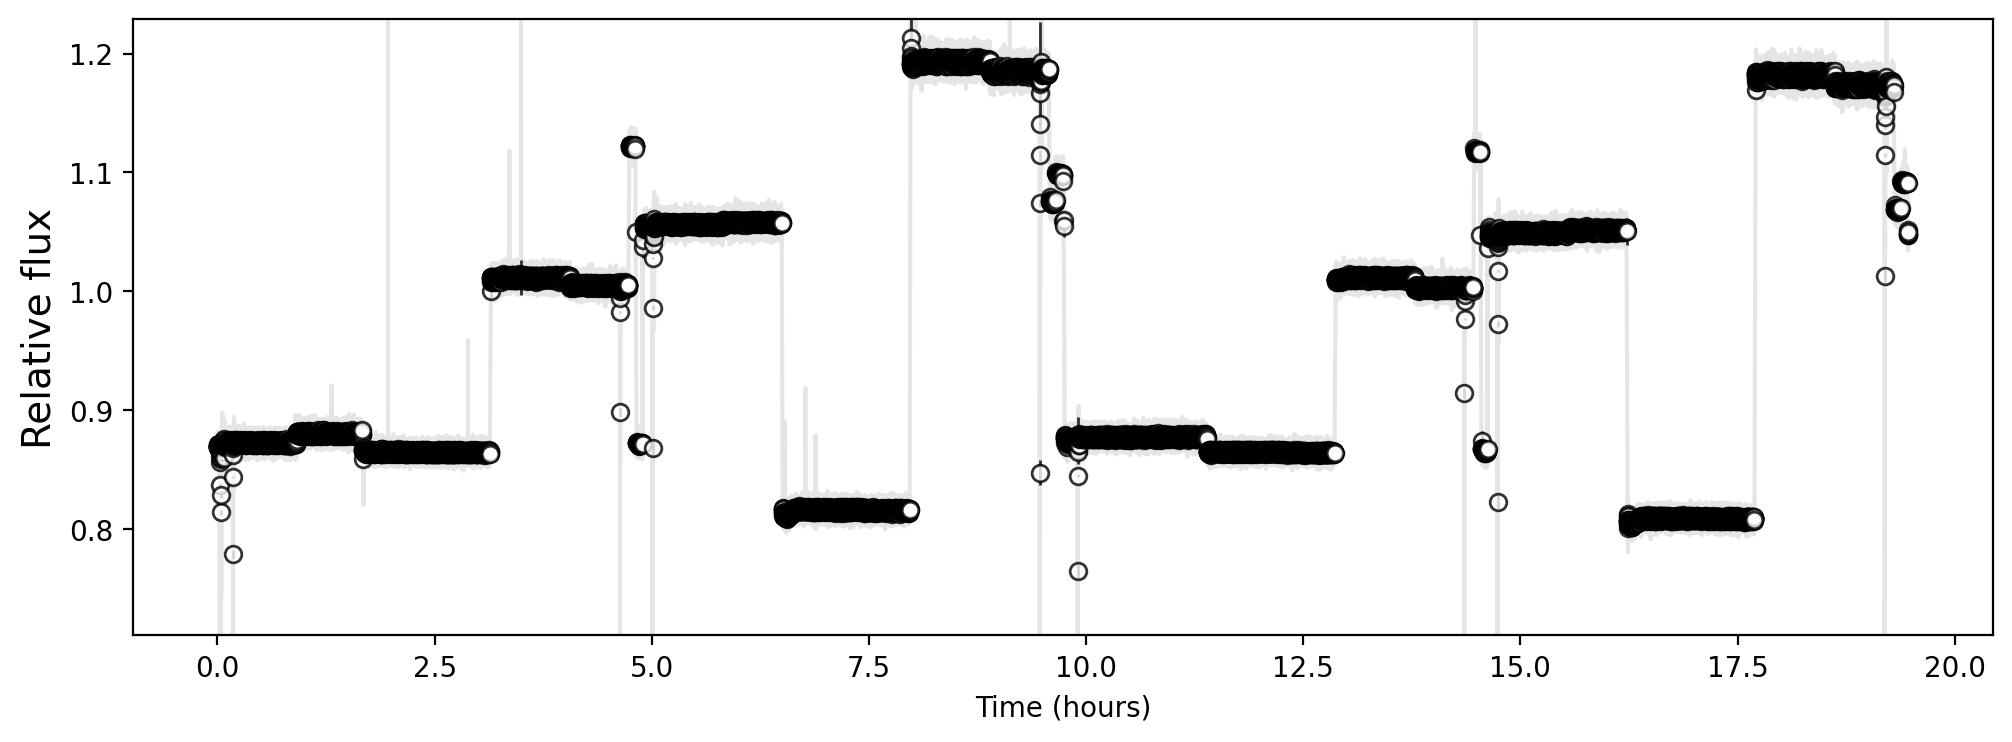

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,4), dpi=200)

spk.optimize_photometry()

ax = spk.timeseries_binned_plot(spk.fg_time, spk.fg_flux)

We can see that the timeseries is broken up into sepeate pieces. Lets see how the pixel cooridinates, pixel standard deviation and Gaussian fitted amplitude of the guidestar changes overtime. We fitted gaussians to each frame using `spk.gauss2d_fit` and saved the outpput as an astropy table `dat` file, so we can load the table here.

In [13]:
from astropy.io import ascii
gaussfit_table = ascii.read('/Users/galagabits/Developer/FGS-Spelunker/pid2079_observation04_visit1.dat')

array([[<Axes: title={'center': 'Centroid_x'}, xlabel='Time (hours)', ylabel='Pixel'>,
        <Axes: title={'center': 'Centroid_y'}, xlabel='Time (hours)', ylabel='Pixel'>],
       [<Axes: title={'center': 'stddev_x'}, xlabel='Time (hours)', ylabel='Pixel'>,
        <Axes: title={'center': 'stddev_y'}, xlabel='Time (hours)', ylabel='Pixel'>],
       [<Axes: title={'center': 'amplitude'}, xlabel='Time (hours)', ylabel='Counts'>,
        <Axes: title={'center': 'theta'}, xlabel='Time (hours)', ylabel='Radians'>],
       [<Axes: title={'center': 'offset'}, xlabel='Time (mjd)', ylabel='Counts'>,
        <Axes: >]], dtype=object)

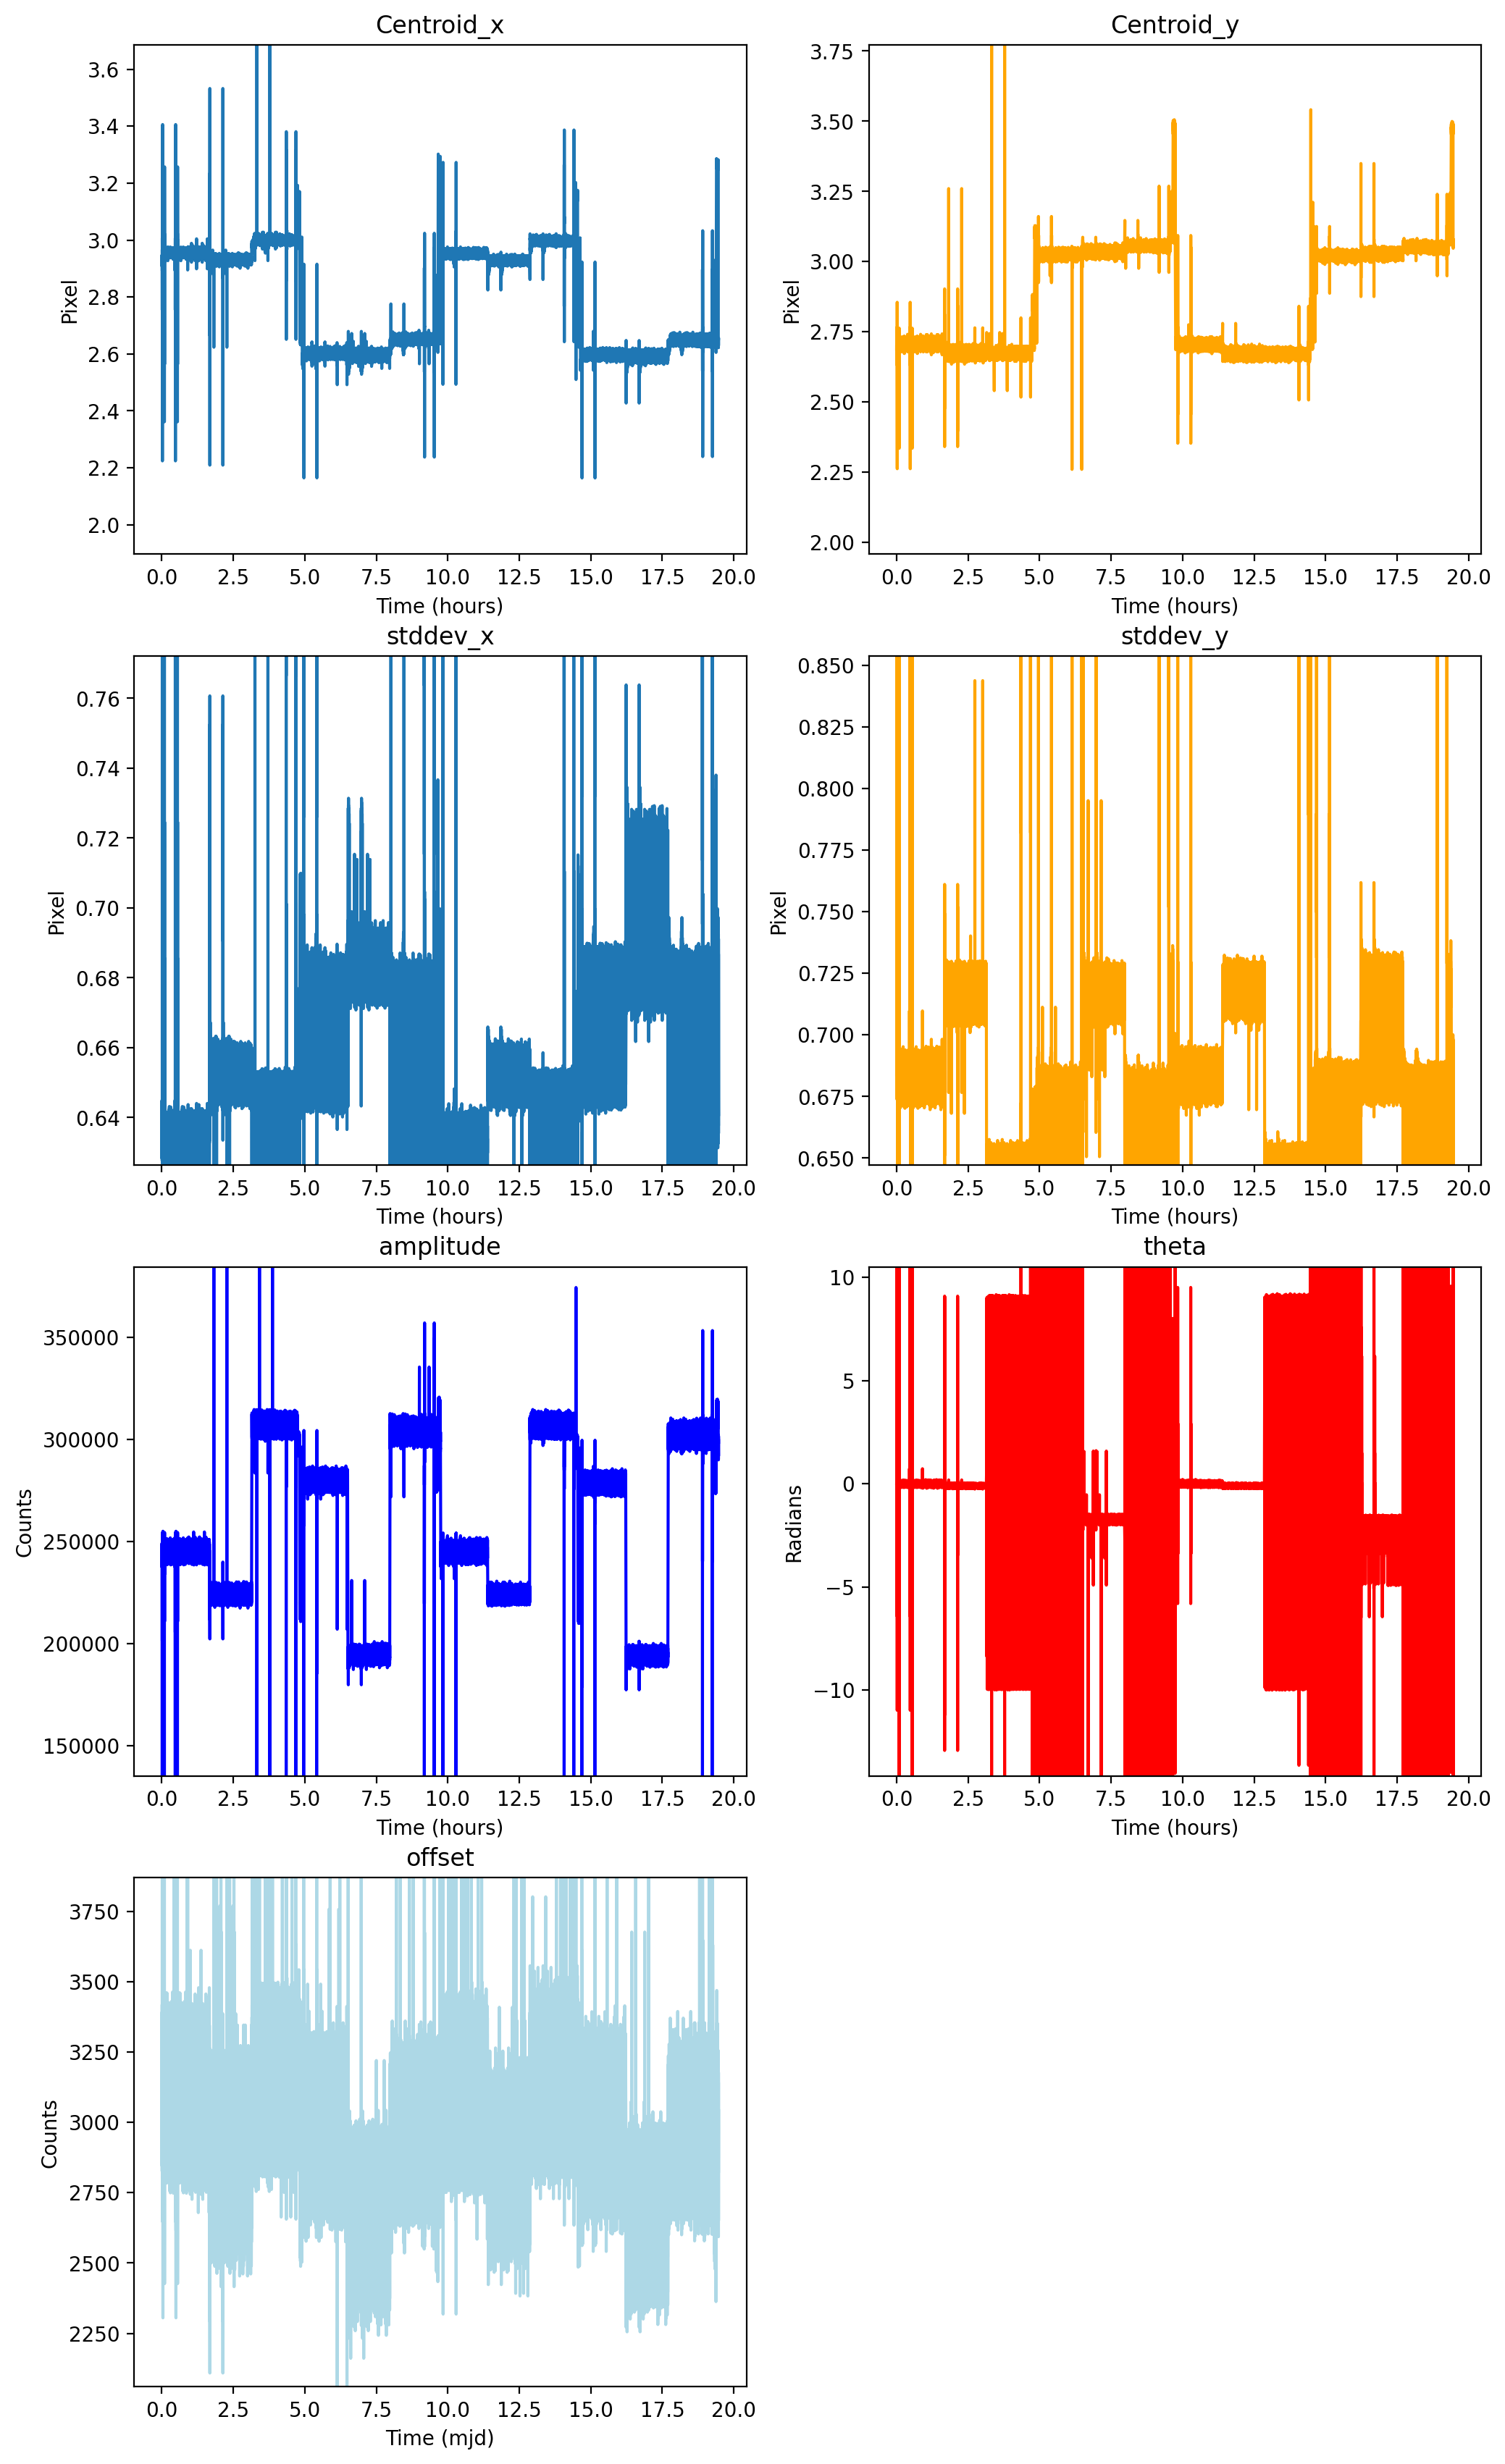

In [14]:
spk.timeseries_list_plot(gaussfit_table, spk.fg_time)

We can clearly see that there are some periodic changes in the centroids every 0.2mjd with even smaller changes within. Lets zoom into one of the centroid plots.

(59976.03, 59976.05)

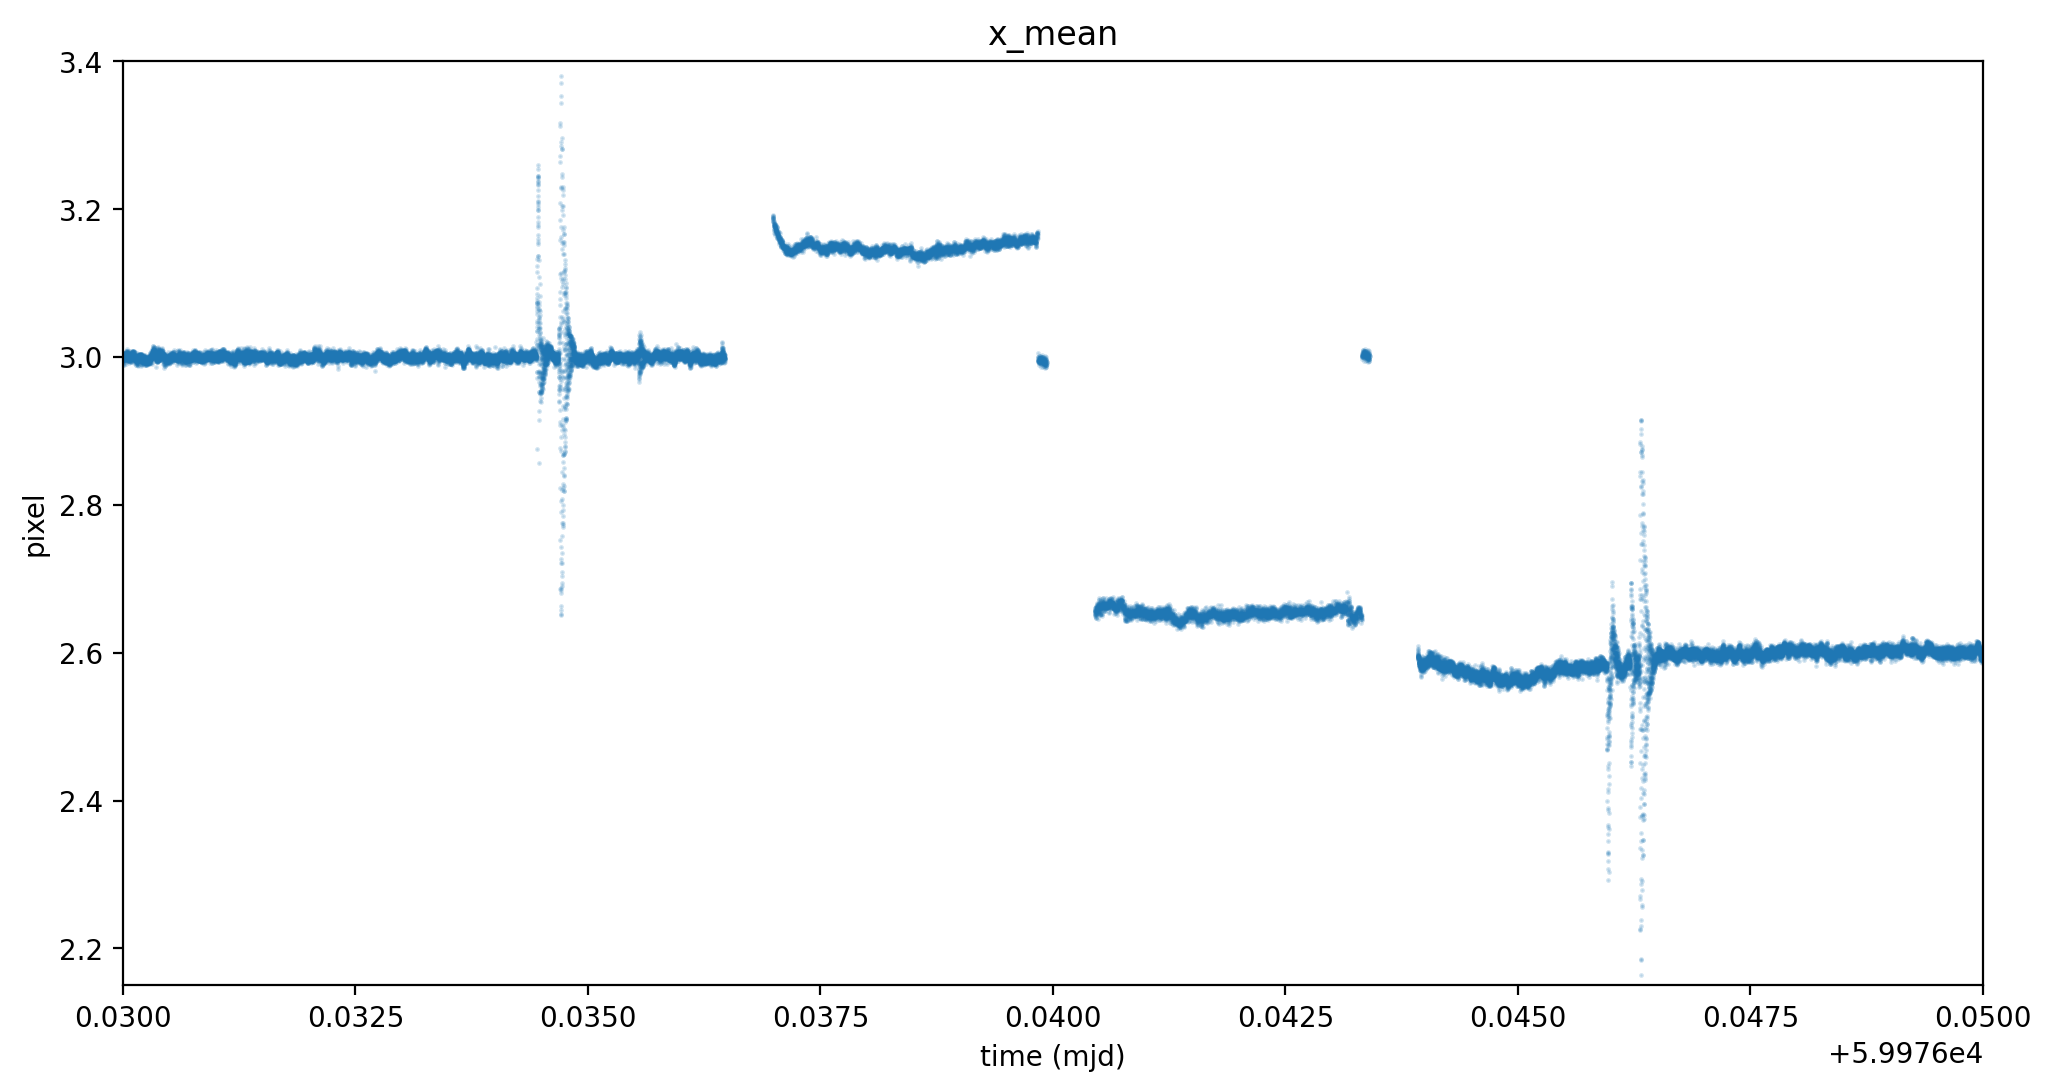

In [22]:
fig, ax = plt.subplots(figsize=(12,6), dpi=200)

ax.scatter(spk.fg_time, gaussfit_table['x_mean'], s=0.5, alpha=0.2)
ax.set_ylabel('pixel')
ax.set_xlabel('time (mjd)')
ax.set_title('x_mean')
ax.set_ylim(2.15,3.4)
ax.set_xlim(59976.03, 59976.05)

We can see there is multiple events happening. First off, there are certain breaks between the timeseries, which indicates the time where the FGS was not observing. Everytime the FGS starts observing again, the flux changes, even though we know the guidestar is the same. This raises more investigative questions such as why does the flux change after each observation if we are looking at the same target? Additonally, there towards 59976.045 mjd, the x centroid slightly decreases within a fraction of a pixel. This maybe a product of the gaussian function where pixel sensitivity or wide PSF affects the shape of the Gaussians. There is also two events that occur on the ends of the timeseries. Lets zoom into the event on the right and apply mnemonics.

(59976.0475, 59976.0495)

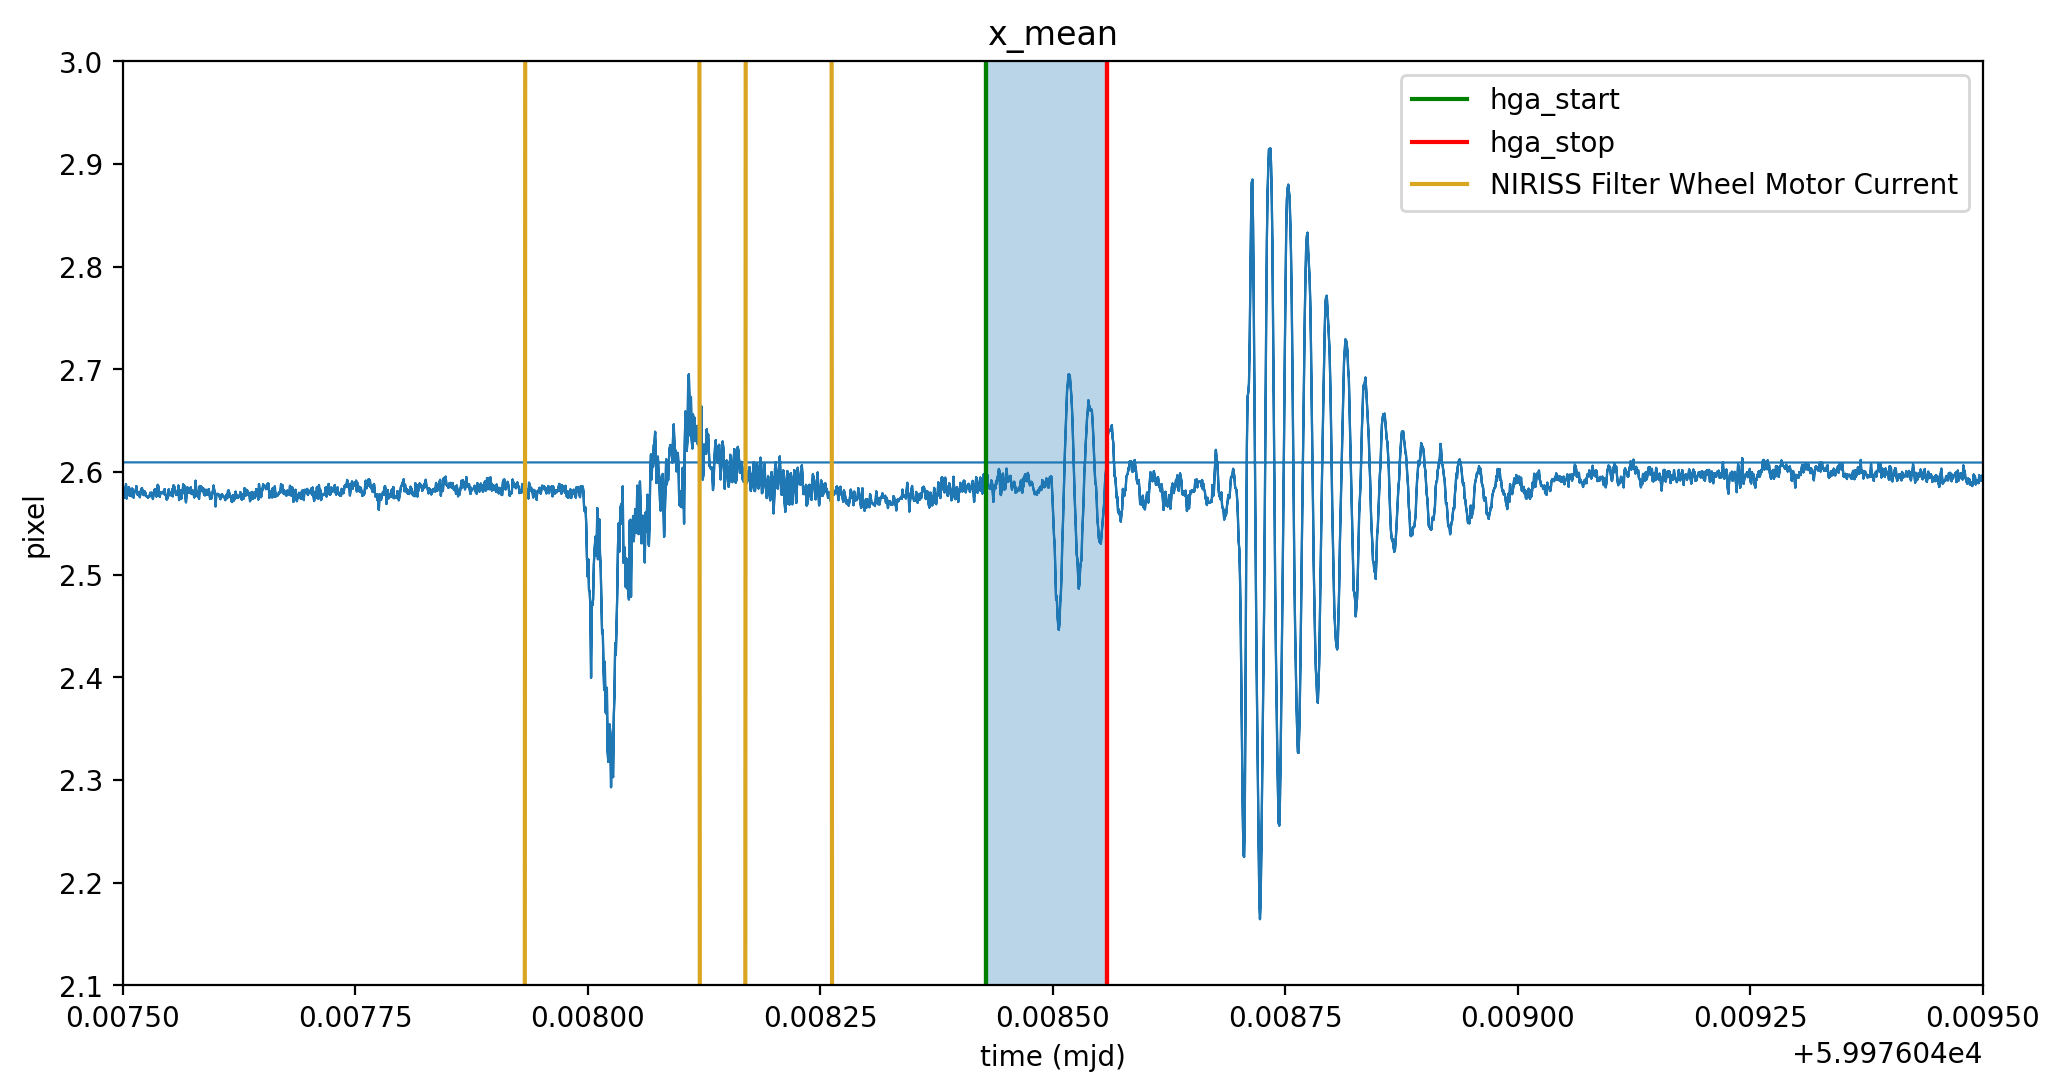

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,6), dpi=200)

ax.plot(spk.fg_time, gaussfit_table['x_mean'], linewidth=.8)

ax = spk.mnemonics('SA_ZHGAUPST', 59976.0475, 59976.05)
ax1 = spk.mnemonics('INIS_FWMTRCURR', 59976.0475, 59976.05)

ax.legend()

ax.set_ylabel('pixel')
ax.set_xlabel('time (mjd)')
ax.set_title('x_mean')
ax.set_ylim(2.1,3.0)
ax.set_xlim(59976.0475, 59976.0495)

We can clearly see that some of the centroid movement can be attributed to the high-gain antenna (HGA) and even events from the NIRISS Filter Wheel.

Lastly, lets create a spatial animation of the timeseries for the guidestar for another event.

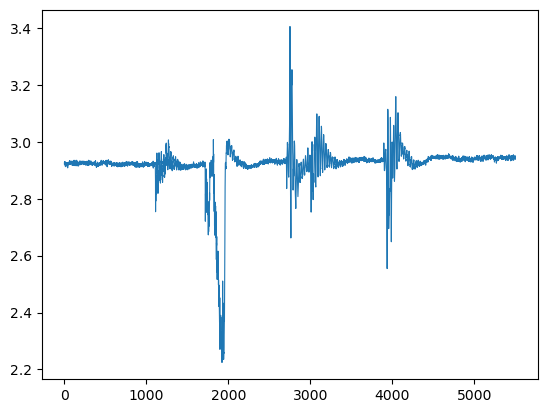

In [17]:
plt.plot(gaussfit_table['x_mean'][51500:57000], linewidth=.8)
plt.show()

2023-07-18 21:04:16,308	INFO worker.py:1636 -- Started a local Ray instance.


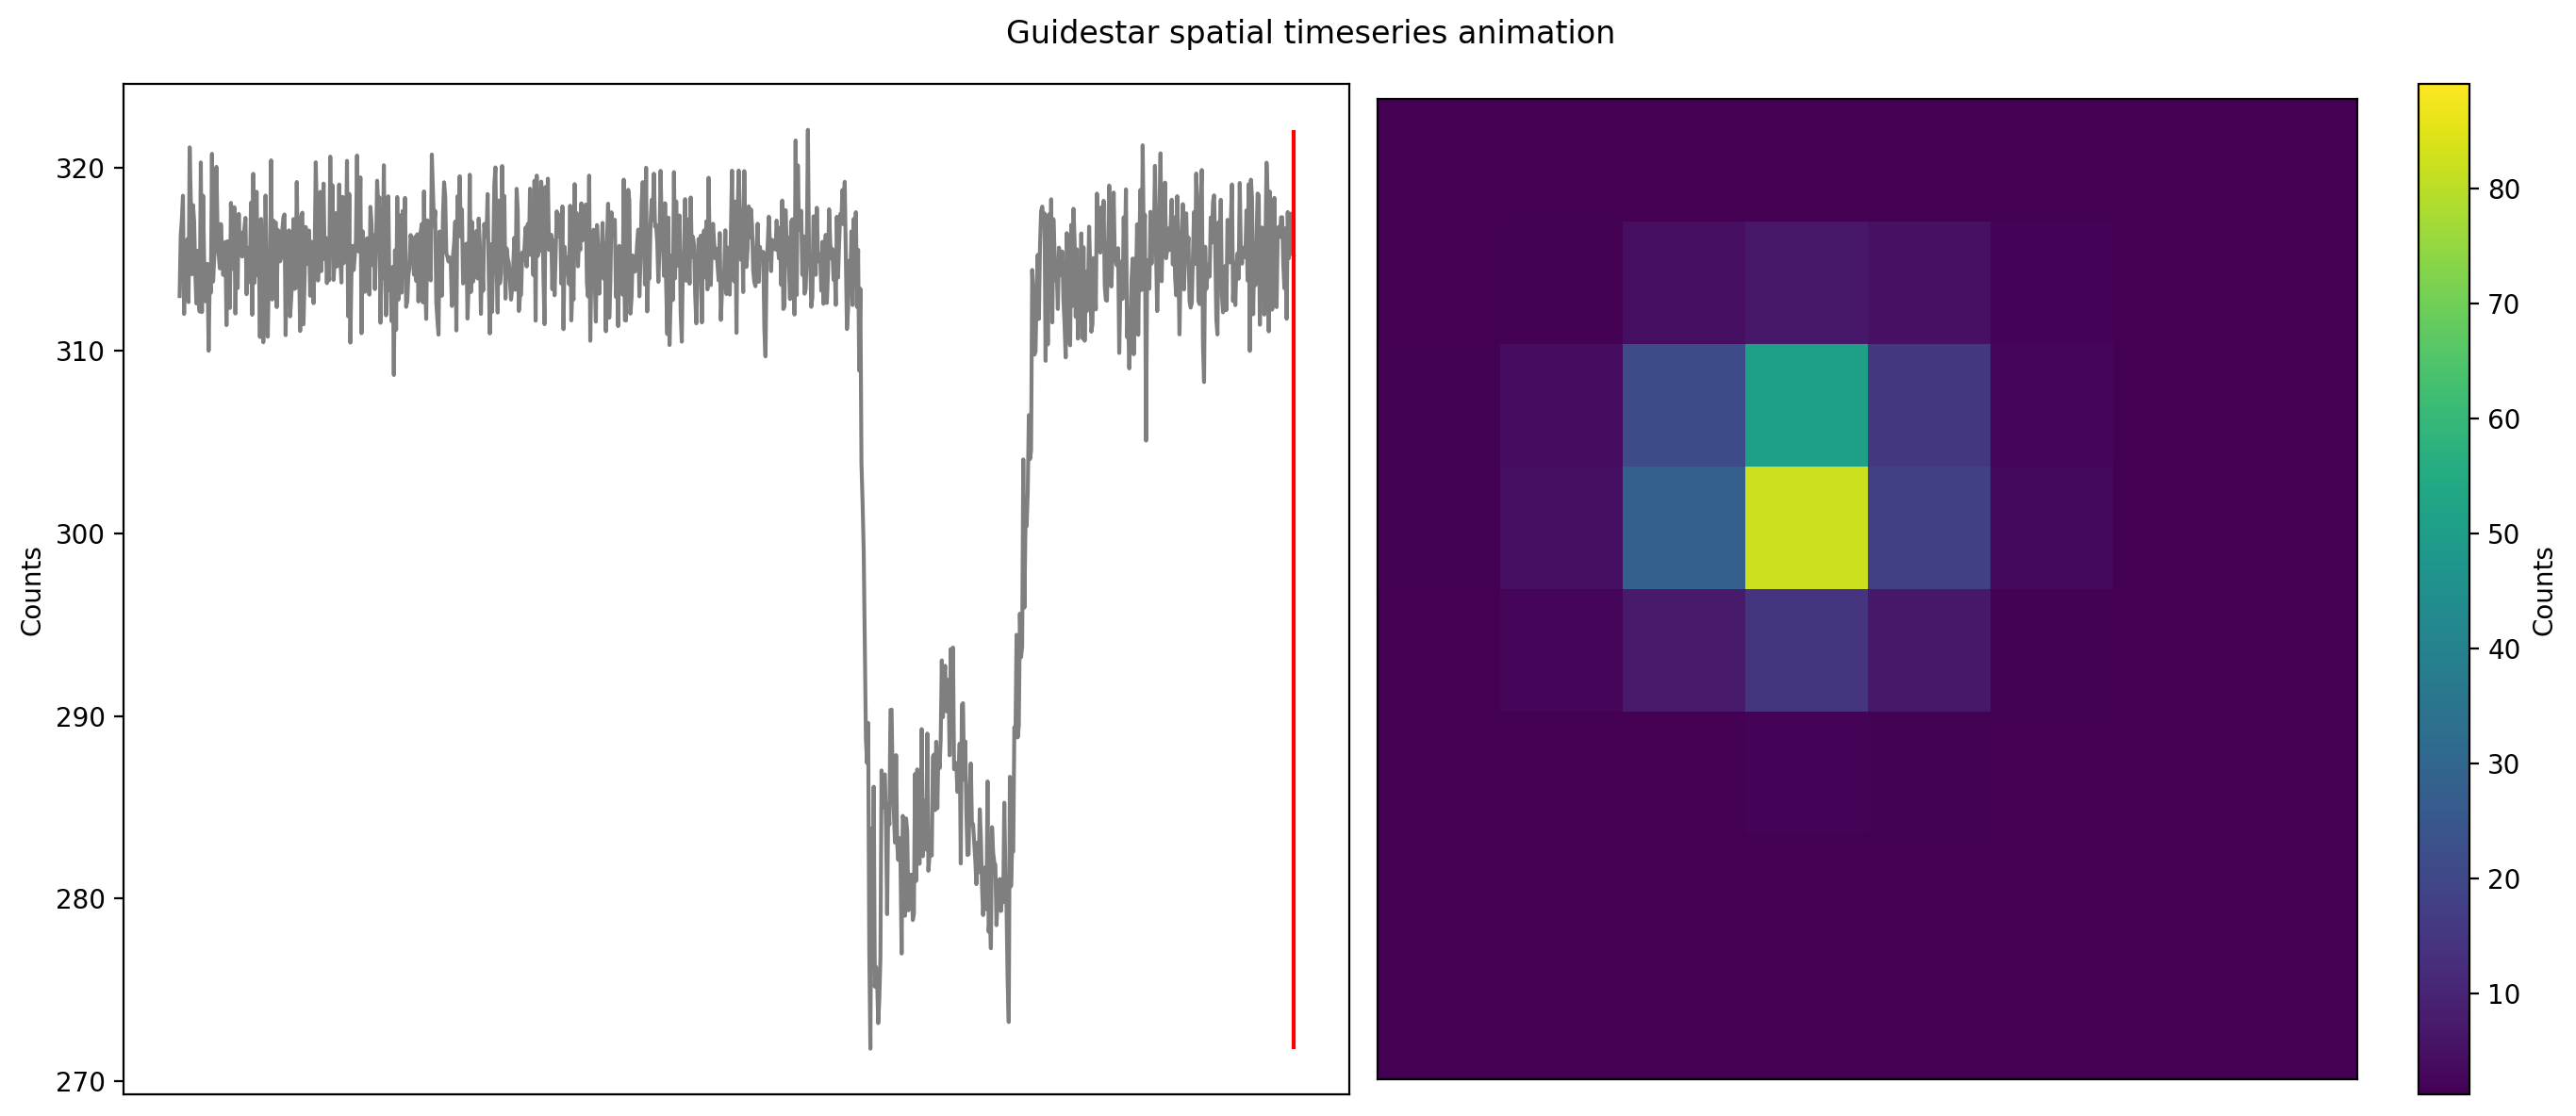

In [18]:
filename = '/Users/ddeal/JWST-Treasure-Chest/event1_2079_xmean.gif'
spk.flux_spatial_timelapse_animation(spk.fg_array[52000:53000], spk.fg_flux[52000:53000], filename=filename)

![](/Users/ddeal/JWST-Treasure-Chest-2023/JWST-FGS-Spelunker-Repos/JWST-FGS-Spelunker/plots/1541movie.gif)